In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import missingno         as msno

import gc
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Exploración básica

In [2]:
path = Path('/run/media/javi/NVMe/Datasets/Kaggle/ashrae-energy-prediction')
! ls {path}

building_metadata.csv  test.csv   weather_test.csv
sample_submission.csv  train.csv  weather_train.csv


In [3]:
%%time
metadata_df       = pd.read_csv(path / 'building_metadata.csv')
train_df          = pd.read_csv(path / 'train.csv',         parse_dates=['timestamp'])
test_df           = pd.read_csv(path / 'test.csv',          parse_dates=['timestamp'])
weather_train_df  = pd.read_csv(path / 'weather_train.csv', parse_dates=['timestamp'])
weather_test_df   = pd.read_csv(path / 'weather_test.csv',  parse_dates=['timestamp'])
sample_submission = pd.read_csv(path / 'sample_submission.csv')

CPU times: user 17.6 s, sys: 1.68 s, total: 19.3 s
Wall time: 20.5 s


## Opcional: Reducir memoria

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


metadata_df      = reduce_mem_usage(metadata_df)
train_df         = reduce_mem_usage(train_df)
test_df          = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df  = reduce_mem_usage(weather_test_df)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


## ¿Qué hay en los CSVs?

In [5]:
display(metadata_df.head())
display(train_df.head())
display(test_df.head())
display(weather_train_df.head())
display(weather_test_df.head())

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


## ¿Hay NaNs? ¿Faltan datos?

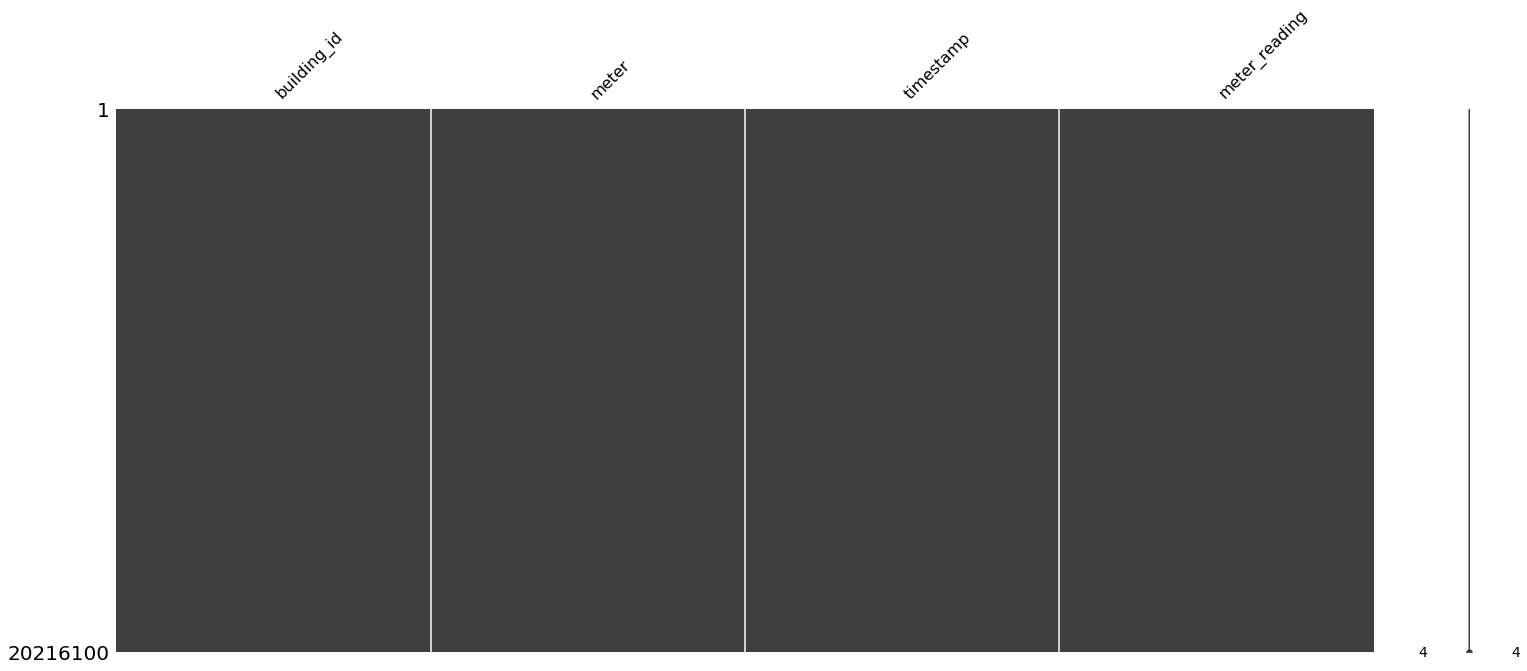

In [6]:
msno.matrix(train_df);

In [6]:
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent missing'])

print("Train")
display(check_missing(train_df))
display(check_missing(weather_train_df))

print("Test")
display(check_missing(test_df))
display(check_missing(weather_test_df))

print("Buildings")
display(check_missing(metadata_df))

Train


,Total,Percent missing
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


,Total,Percent missing
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


Test


,Total,Percent missing
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0
row_id,0,0.0


,Total,Percent missing
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


Buildings


,Total,Percent missing
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


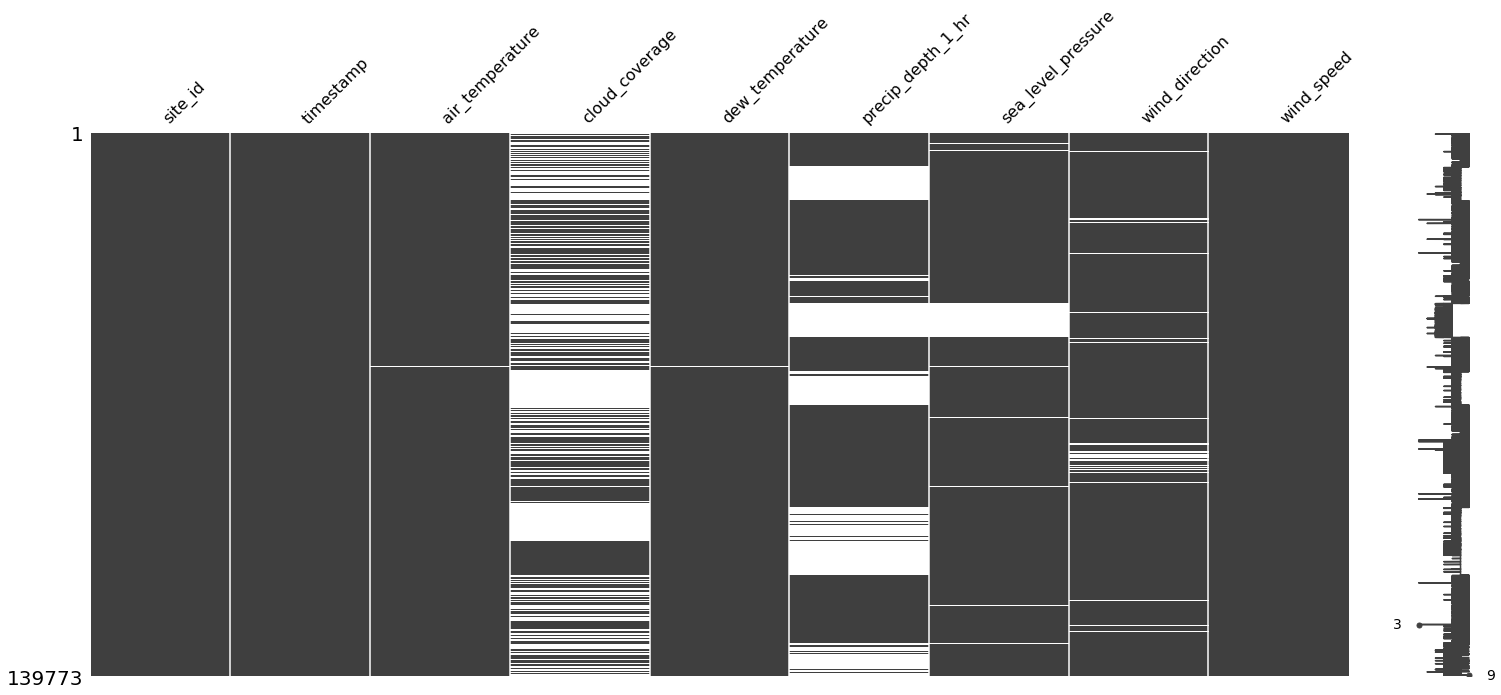

In [11]:
msno.matrix(weather_train_df);

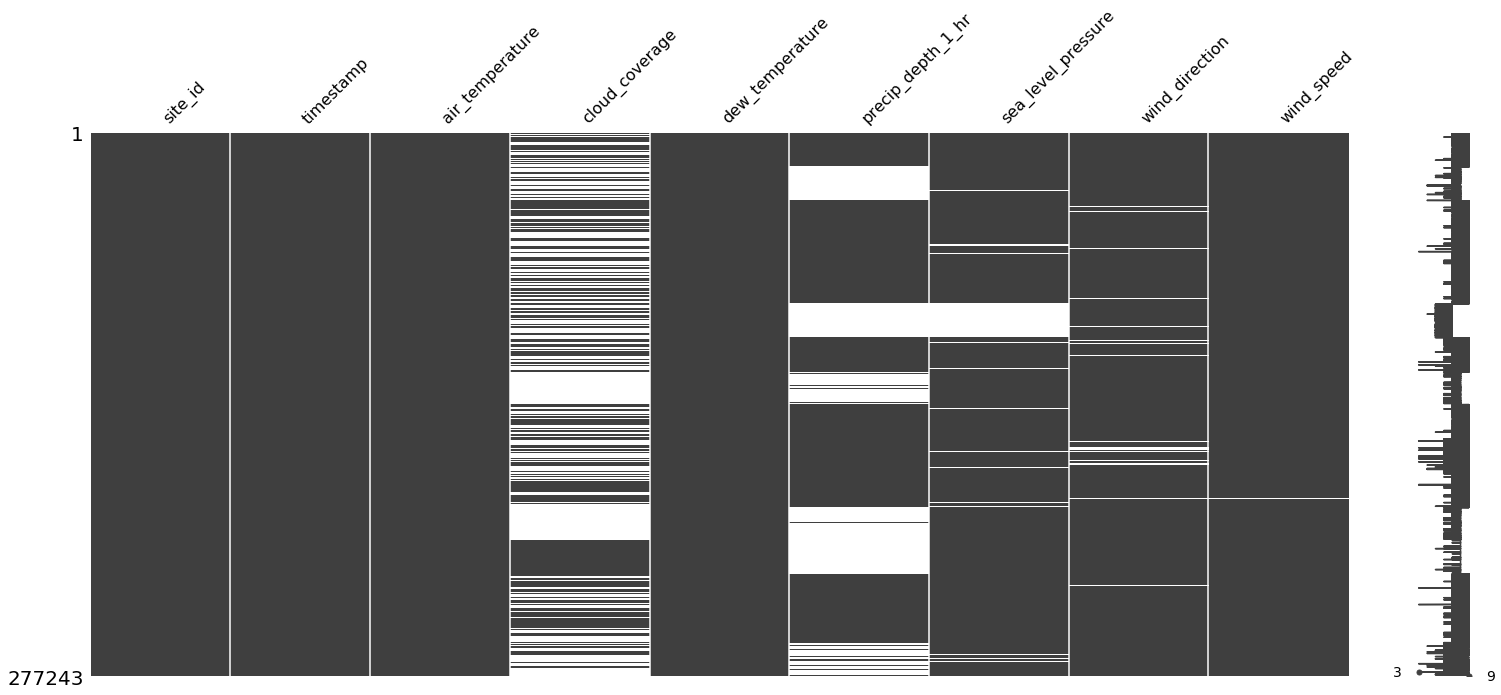

In [12]:
msno.matrix(weather_test_df)

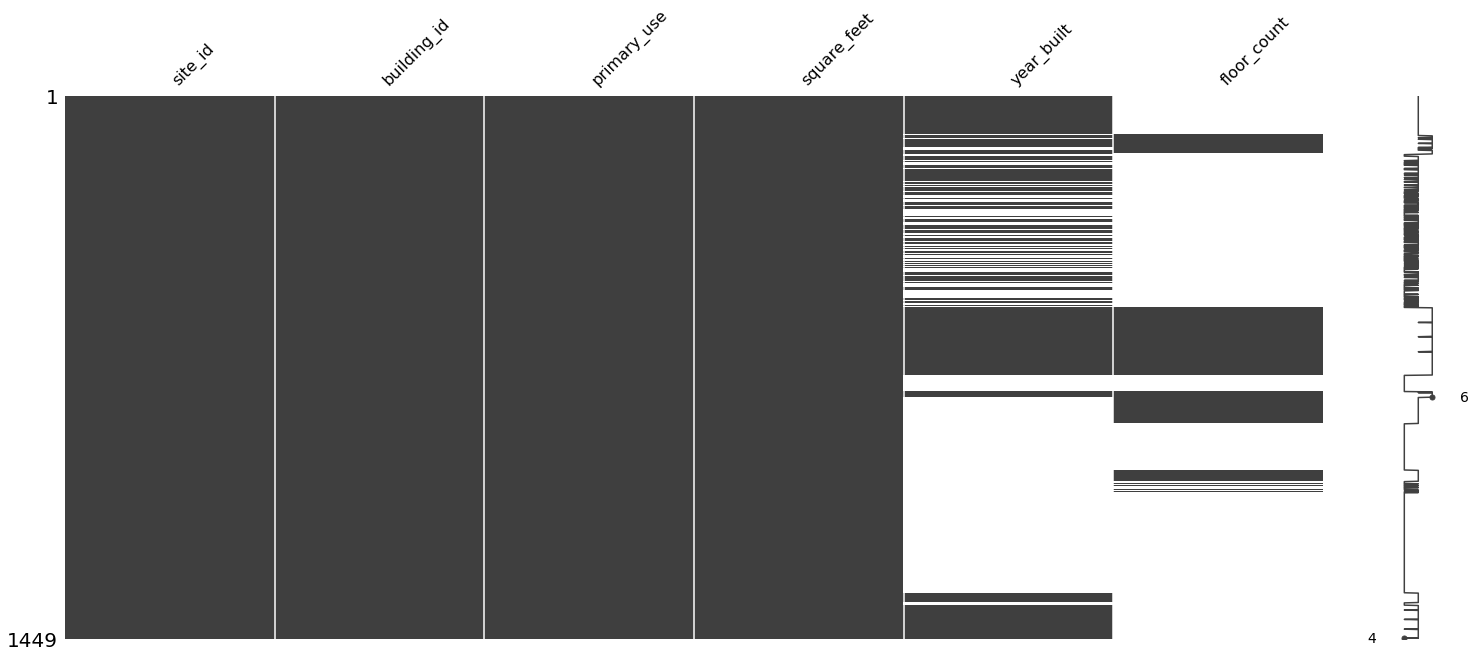

In [13]:
msno.matrix(metadata_df)

## Distribución de la variable objetivo: meter_reading

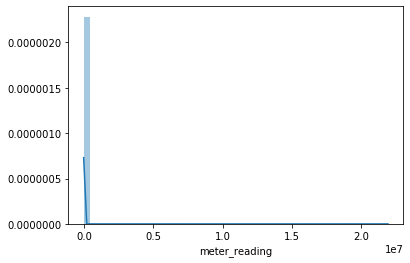

In [7]:
sns.distplot(train_df['meter_reading'])

In [8]:
train_df_1000 = train_df[train_df['meter_reading']<=1000]

q_99 = train_df['meter_reading'].quantile(0.99)
train_df_q99 = train_df[train_df['meter_reading']<=q_99]

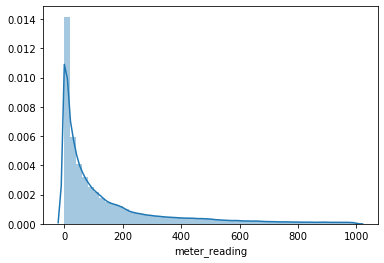

In [9]:
sns.distplot(train_df_1000['meter_reading'])

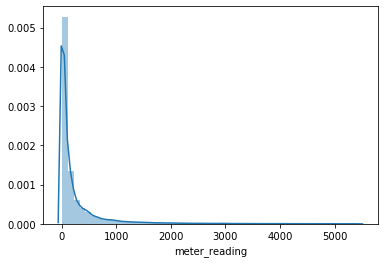

In [10]:
sns.distplot(train_df_q99['meter_reading'])

## Transformacion logaritmica de la variable objetivo

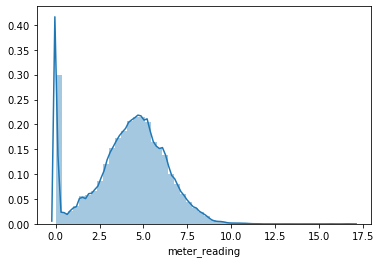

In [11]:
sns.distplot(np.log1p(train_df['meter_reading']))

## Extiten 4 tipos de energia a medir
0. electricity
1. chilledwater
2. steam
3. hotwater

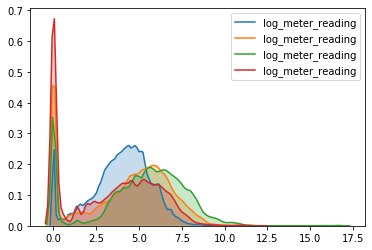

In [7]:
train_df["log_meter_reading"] = np.log1p(train_df['meter_reading'])

for meter in range(4):
    sns.kdeplot(train_df[train_df['meter']==meter]["log_meter_reading"], shade=True)

## Fechas

In [12]:
TS = 'timestamp'
print(f'Train from {train_df[TS].min()} to {train_df[TS].max()}')
print(f'Test  from { test_df[TS].min()} to { test_df[TS].max()}')

Train from 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Test  from 2017-01-01 00:00:00 to 2018-12-31 23:00:00


# Alinear Timestamps (high temperature will be 14:00)

In [14]:
weather = pd.concat([weather_train_df, weather_test_df],ignore_index=True)
del weather_train_df
del weather_test_df


weather_key   = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(
    subset=weather_key).sort_values(by=weather_key).copy()

del weather

temp_skeleton.head()

,site_id,timestamp,air_temperature
0,0,2016-01-01 00:00:00,25.000000
1,0,2016-01-01 01:00:00,24.406250
2,0,2016-01-01 02:00:00,22.796875
3,0,2016-01-01 03:00:00,21.093750
4,0,2016-01-01 04:00:00,20.000000


### Existen 16 lugares distintos

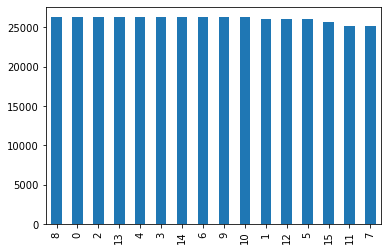

In [20]:
temp_skeleton["site_id"].value_counts().plot.bar()

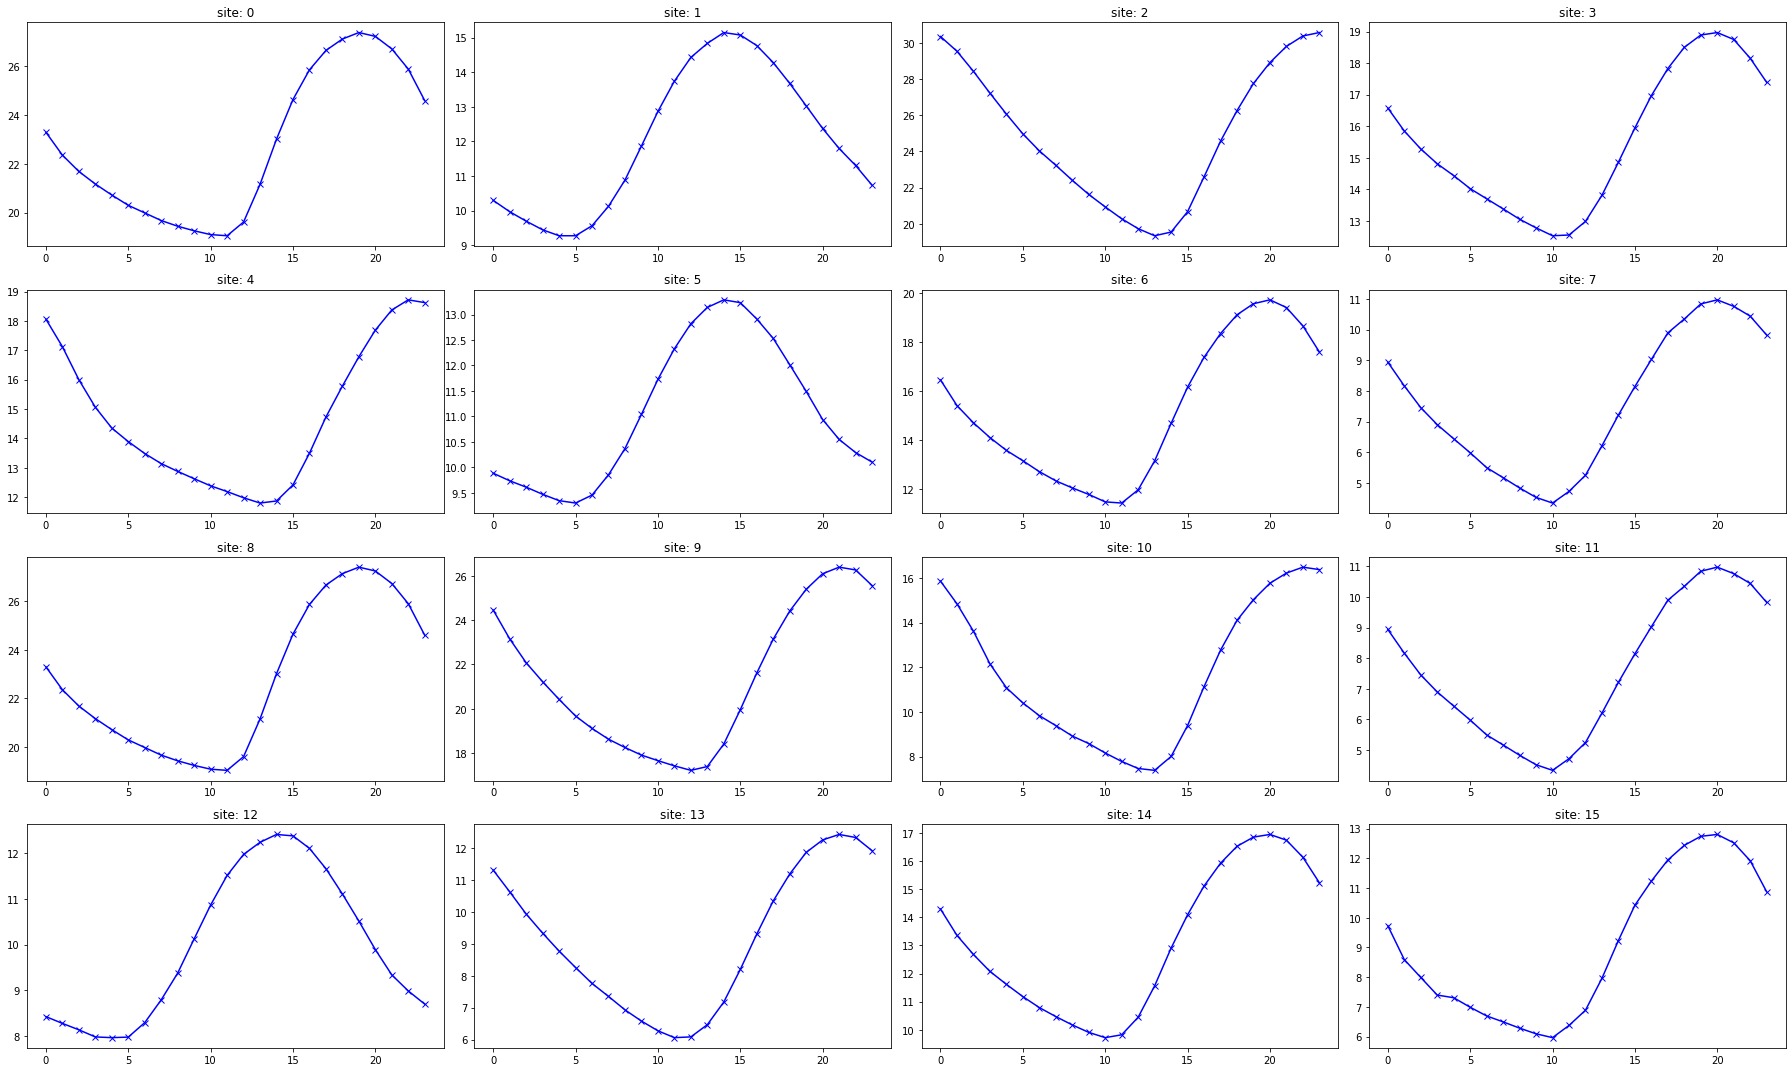

In [16]:
data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del data_to_plot

In [21]:
# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

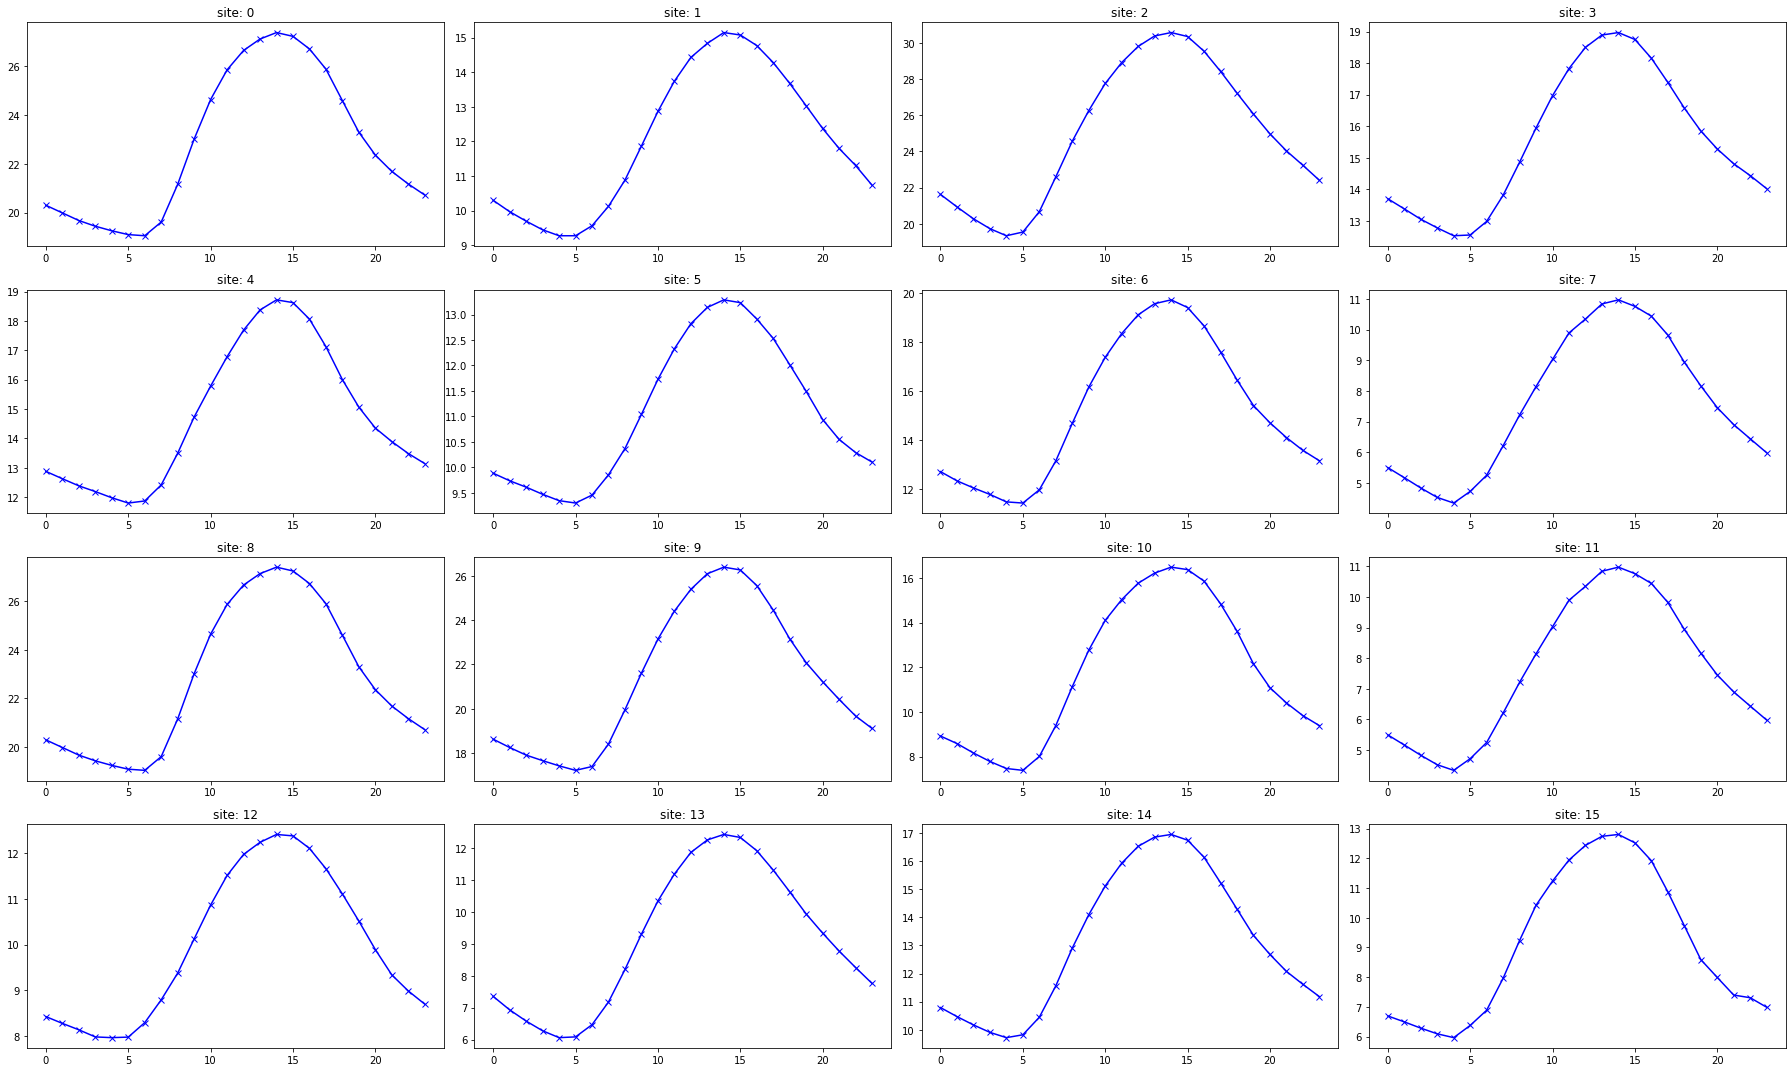

In [22]:
temp_skeleton_align = timestamp_align(temp_skeleton)

data_to_plot = temp_skeleton_align.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del data_to_plot